# US Census Task

The following link lets you download an archive containing an “exercise” US Census dataset: http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip
This US Census dataset contains detailed but anonymized information for approximately 300,000 people.

The archive contains 3 files: 
1. A large training file (csv)
2. Another test file (csv)
3. A metadata file (txt) describing the columns of the two csv files (identical for both)

The goal of this exercise is to model the information contained in the last column (42nd), i.e., whether a person makes more or less than $50,000 per year, from the information contained in the other columns. The exercise here consists of modeling a binary variable.

Work with Python (or R) to carry out the following steps:
1. Load the train and test files.
2. Perform an exploratory analysis on the data and create some relevant visualisations.
3. Clean, preprocess, and engineer features in the training data, with the aim of building a data set that a model will perform well on.
4. Create a model using these features to predict whether a person earns more or less than $50,000 per year. Here, the idea is for you to test a few different models, and see whether there are any techniques you can apply to improve performance over your first results.
5. Choose the model that appears to have the highest performance based on a comparison between reality (the 42nd variable) and the model’s prediction.
6. Apply your model to the test file and measure its real performance on it (same method as above).

The goal of this exercise is not to create the best or the purest model, but rather to describe the steps you took to accomplish it.
Explain areas that may have been the most challenging for you.
Find clear insights on the profiles of the people that make more than $50,000 / year. For example, which variables seem to be the most correlated with this phenomenon?
Finally, you push your code on GitHub to share it with me, or send it via email.

Once again, the goal of this exercise is not to solve this problem, but rather to spend a few hours on it and to thoroughly explain your approach.

# Imports

In [1]:
import requests, zipfile, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

# LightGBM
from lightgbm import LGBMClassifier

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# PyTorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Download the Data

In [2]:
zipurl = 'https://t.lever-analytics.com/email-link?dest=http%3A%2F%2Fthomasdata.s3.amazonaws.com%2Fds%2Fus_census_full.zip&eid=b5c393b0-02b0-409e-b899-52d66d90cf44&idx=1&token=jcOR6AbBgoc9M-r1CGMmuQ0lnLk'

# get request
response = requests.get(zipurl)

zname = "us_census_full.zip"
zfile = open(zname, 'wb')
zfile.write(response.content)
zfile.close()

# unzip the file
with zipfile.ZipFile('us_census_full.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Loading the Data

In [3]:
train_df = pd.read_csv('us_census_full/census_income_learn.csv', header=None)
test_df = pd.read_csv('us_census_full/census_income_test.csv', header=None)

print(train_df.shape, test_df.shape)

train_df.head()

(199523, 42) (99762, 42)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


# Column Names

The data does not have column headers. I will read into the meta file to extract the column names and then asssign them to the relevant column.

**Note:** As mentioned in the meta file, I will ignore the 'instance weight' feature. I will do this by dropping it.

In [4]:
with open('us_census_full/census_income_metadata.txt') as meta_file:
    meta_lines = meta_file.readlines()

last42_lines = meta_lines[-42:]

col_list = []
for line in last42_lines:
    col_list.append(line.split(':')[0])
    
col_list.remove('| instance weight')
col_list.append('income')

col_list = [col.replace(' ', '_') for col in col_list]

train_df.columns = col_list
test_df.columns = col_list

train_df.drop(columns='instance_weight', inplace=True)
test_df.drop(columns='instance_weight', inplace=True)

train_df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


# Removing Duplicate Samples

We can take a look at how many samples are duplicates. These duplicate samples are then removed.

In [5]:
print('Number of duplicated training samples: ', train_df.duplicated().sum())
print('Number of duplicated test samples: ', test_df.duplicated().sum())

print('Data shape before dropping duplicates: ',train_df.shape, test_df.shape)

train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

print('Data shape after dropping duplicates: ',train_df.shape, test_df.shape)

Number of duplicated training samples:  46627
Number of duplicated test samples:  20898
Data shape before dropping duplicates:  (199523, 41) (99762, 41)
Data shape after dropping duplicates:  (152896, 41) (78864, 41)


# Removing Null Samples with Null Values

We can all look at the number of samples which are null. Luckily, there are none.

In [6]:
print('Number of null training samples: ', train_df.isnull().sum(axis=0).sum())
print('Number of null test samples: ', test_df.isnull().sum(axis=0).sum())

Number of null training samples:  0
Number of null test samples:  0


# Class Imbalance

The first thing I am interested in at is the distribution of the target variable (income). We want to find out two things:

1. **Are the classes balanced or imbalanced?** The classes are imbalanced: roughly ~92% of the training samples are people earning an income below \\$50,000. This imbalance is expected with income data since its classicaly known to be a skewed distribution. Howeber, depending on the model, this imbalance may cause an issue come prediciton time. Why? Consider the extreme case where the target variable is 99\% of the majority class and only 1\% of the minority class. In this case one can always predict the majority class and always be 99\% accurate. One way to address this issue is to use resampling techniques to fix the class imabalance, for example, upsampling the minority class (income>\\$50,000) or downsampling the majority class (income<\\$50,000).


2. **Does the training data represent the test data?** The class imbalance is stable across the two data sets, therefore, the class imbalance in the training set appears to represent the class imbalance in the test set. This is a good thing. Why? If models are trained on data that does not represent the test data then they are unlikley to perform well at test time.


**NOTE:** I will not be performing any class re-balancing. Instead, I am going to just simply compare models. Some of these models will suffer from this imbalance and some will not, for example, tree based methods are good at handling imbalanced data, whereas logistic regression models are not. I will try to point this out as we go through the models by using one metric that accounts (balanced accuracy) for this imbalance and one that doesnt (accuracy).

In [7]:
print('Training Data')
print(train_df['income'].value_counts())

print()

print('Test Data')
print(test_df['income'].value_counts())

Training Data
 - 50000.    140529
 50000+.      12367
Name: income, dtype: int64

Test Data
 - 50000.    72678
 50000+.      6186
Name: income, dtype: int64


# Data Types

Some of the features are continious variables and some are categorical. The continious data types will be fine to work with immediately, but the categorical data is encocded as dtype 'object' so they need a little cleaning before we can dive into the exploratory analysis.

In [8]:
cont_feats = list(train_df.select_dtypes(exclude='object').columns)
cat_feats = list(train_df.select_dtypes(include='object').columns)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152896 entries, 0 to 199522
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   age                                         152896 non-null  int64 
 1   class_of_worker                             152896 non-null  object
 2   detailed_industry_recode                    152896 non-null  int64 
 3   detailed_occupation_recode                  152896 non-null  int64 
 4   education                                   152896 non-null  object
 5   wage_per_hour                               152896 non-null  int64 
 6   enroll_in_edu_inst_last_wk                  152896 non-null  object
 7   marital_stat                                152896 non-null  object
 8   major_industry_code                         152896 non-null  object
 9   major_occupation_code                       152896 non-null  object
 10  race    

## Continious Data:

We can take a look at some statistics of the continious data and plot some histograms to get a high-level view of them. I will come back to look at some of these features in more detail later on.

In [9]:
train_df[cont_feats].describe()

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
count,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000,152896.000000
mean,39.719371,19.942922,14.672876,72.324279,567.237115,48.664471,257.019255,2.538052,0.228587,1.821061,30.061591,94.490163
std,19.662074,18.234760,14.887964,312.072448,5359.204656,309.511387,2261.405280,2.403920,0.622317,0.559472,23.786471,0.499905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,38.000000,24.000000,10.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,45.000000,94.000000
75%,52.000000,37.000000,29.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,2.000000,2.000000,52.000000,95.000000


**NOTICE:**
1. Few of the features have a mean close to the median which suggests that they come from a skewed distribution
2. Many of the features have a maximum value much greater than the 75% quantile - for example, look at wage_per_hour, capital_gains, capital_losses, etc - which suggests that their could be some very high outlier.
3. The very different maximum values indicates that the features are on different scales.

**We can plot some histograms and boxplots to confirm this...**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000225858DC088>,
      dtype=object)

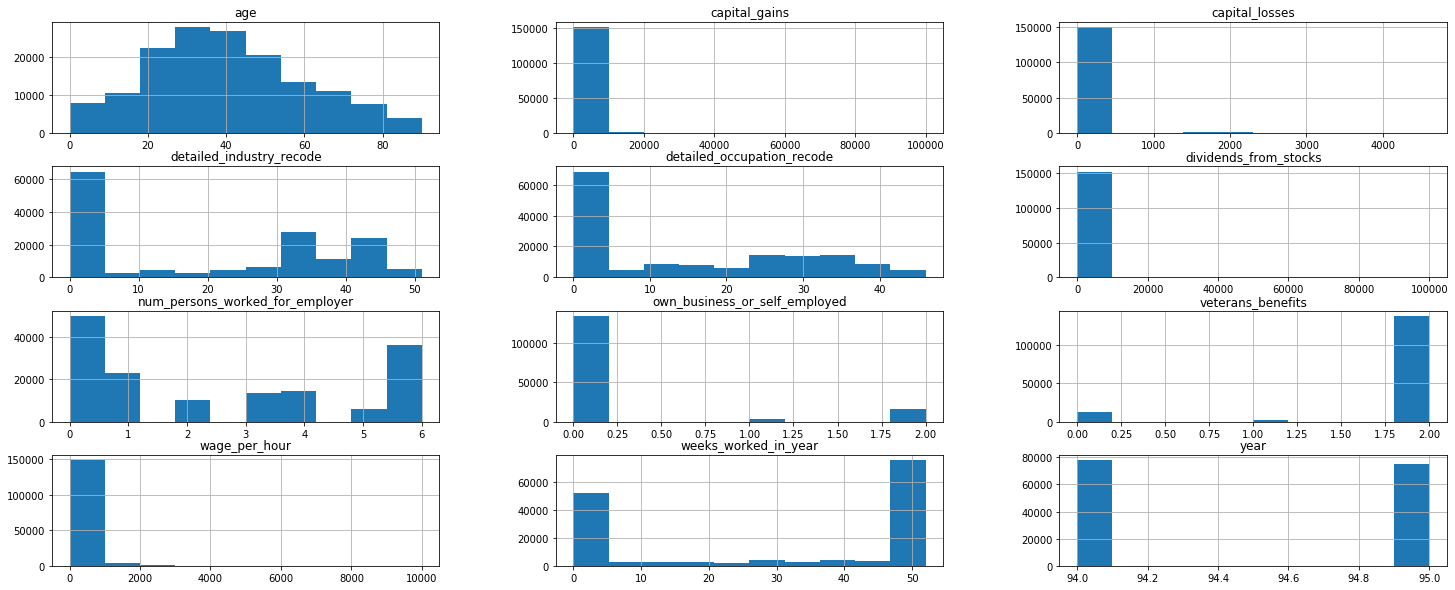

In [10]:
train_df[cont_feats].hist(figsize=(25,10))

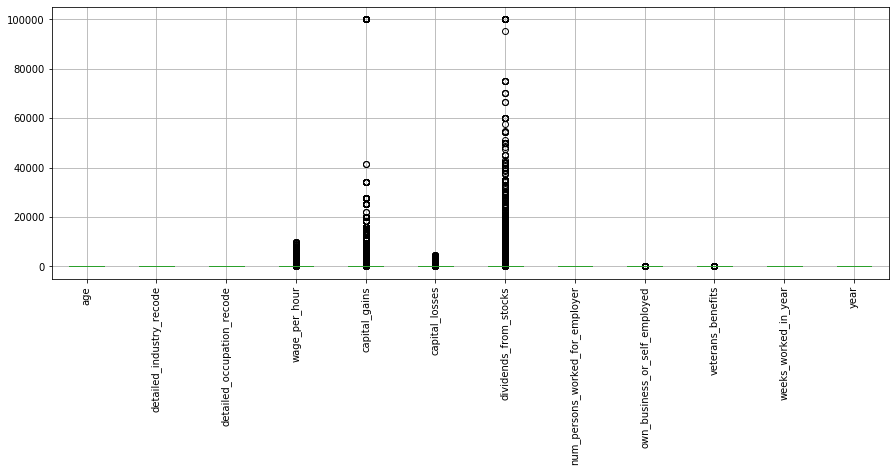

In [11]:
train_df[cont_feats].boxplot(figsize=(15,5), rot=90)

**NOTE:** There are three things to consider her for the continious data:
1. Skew of the features - many of the features are skewed.
2. Scale of the features - many of the features are on very different scales.
3. Outliers of the featurs - some of the features appears to have extreme outliers.

I will not deal with these for now, but they are worth noting.

## Categorical Data

The categorical data in this dataset is not as easy to overview as the continious data. We will first need to do some cleaning by changing them from dtype 'object' to dtype 'category'. I will also strip remove any unnecessary whitespace from the strings.

In [12]:
def objs_to_cats(df):
    '''
    Convert object features to categories.
    Strip any whitespace from the strings.
    '''
    objs = df.select_dtypes('object')
    for col in objs.columns:
        df[col] = df[col].apply(lambda x: x.strip())
        df[col] = df[col].astype('category')
    return df

train_df = objs_to_cats(train_df)
test_df = objs_to_cats(test_df)

train_df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


**WARNING:** I'm going to plot a lot of figures for the categorical features that are, well... not too pretty, but again they will give me a high-level view of these features.

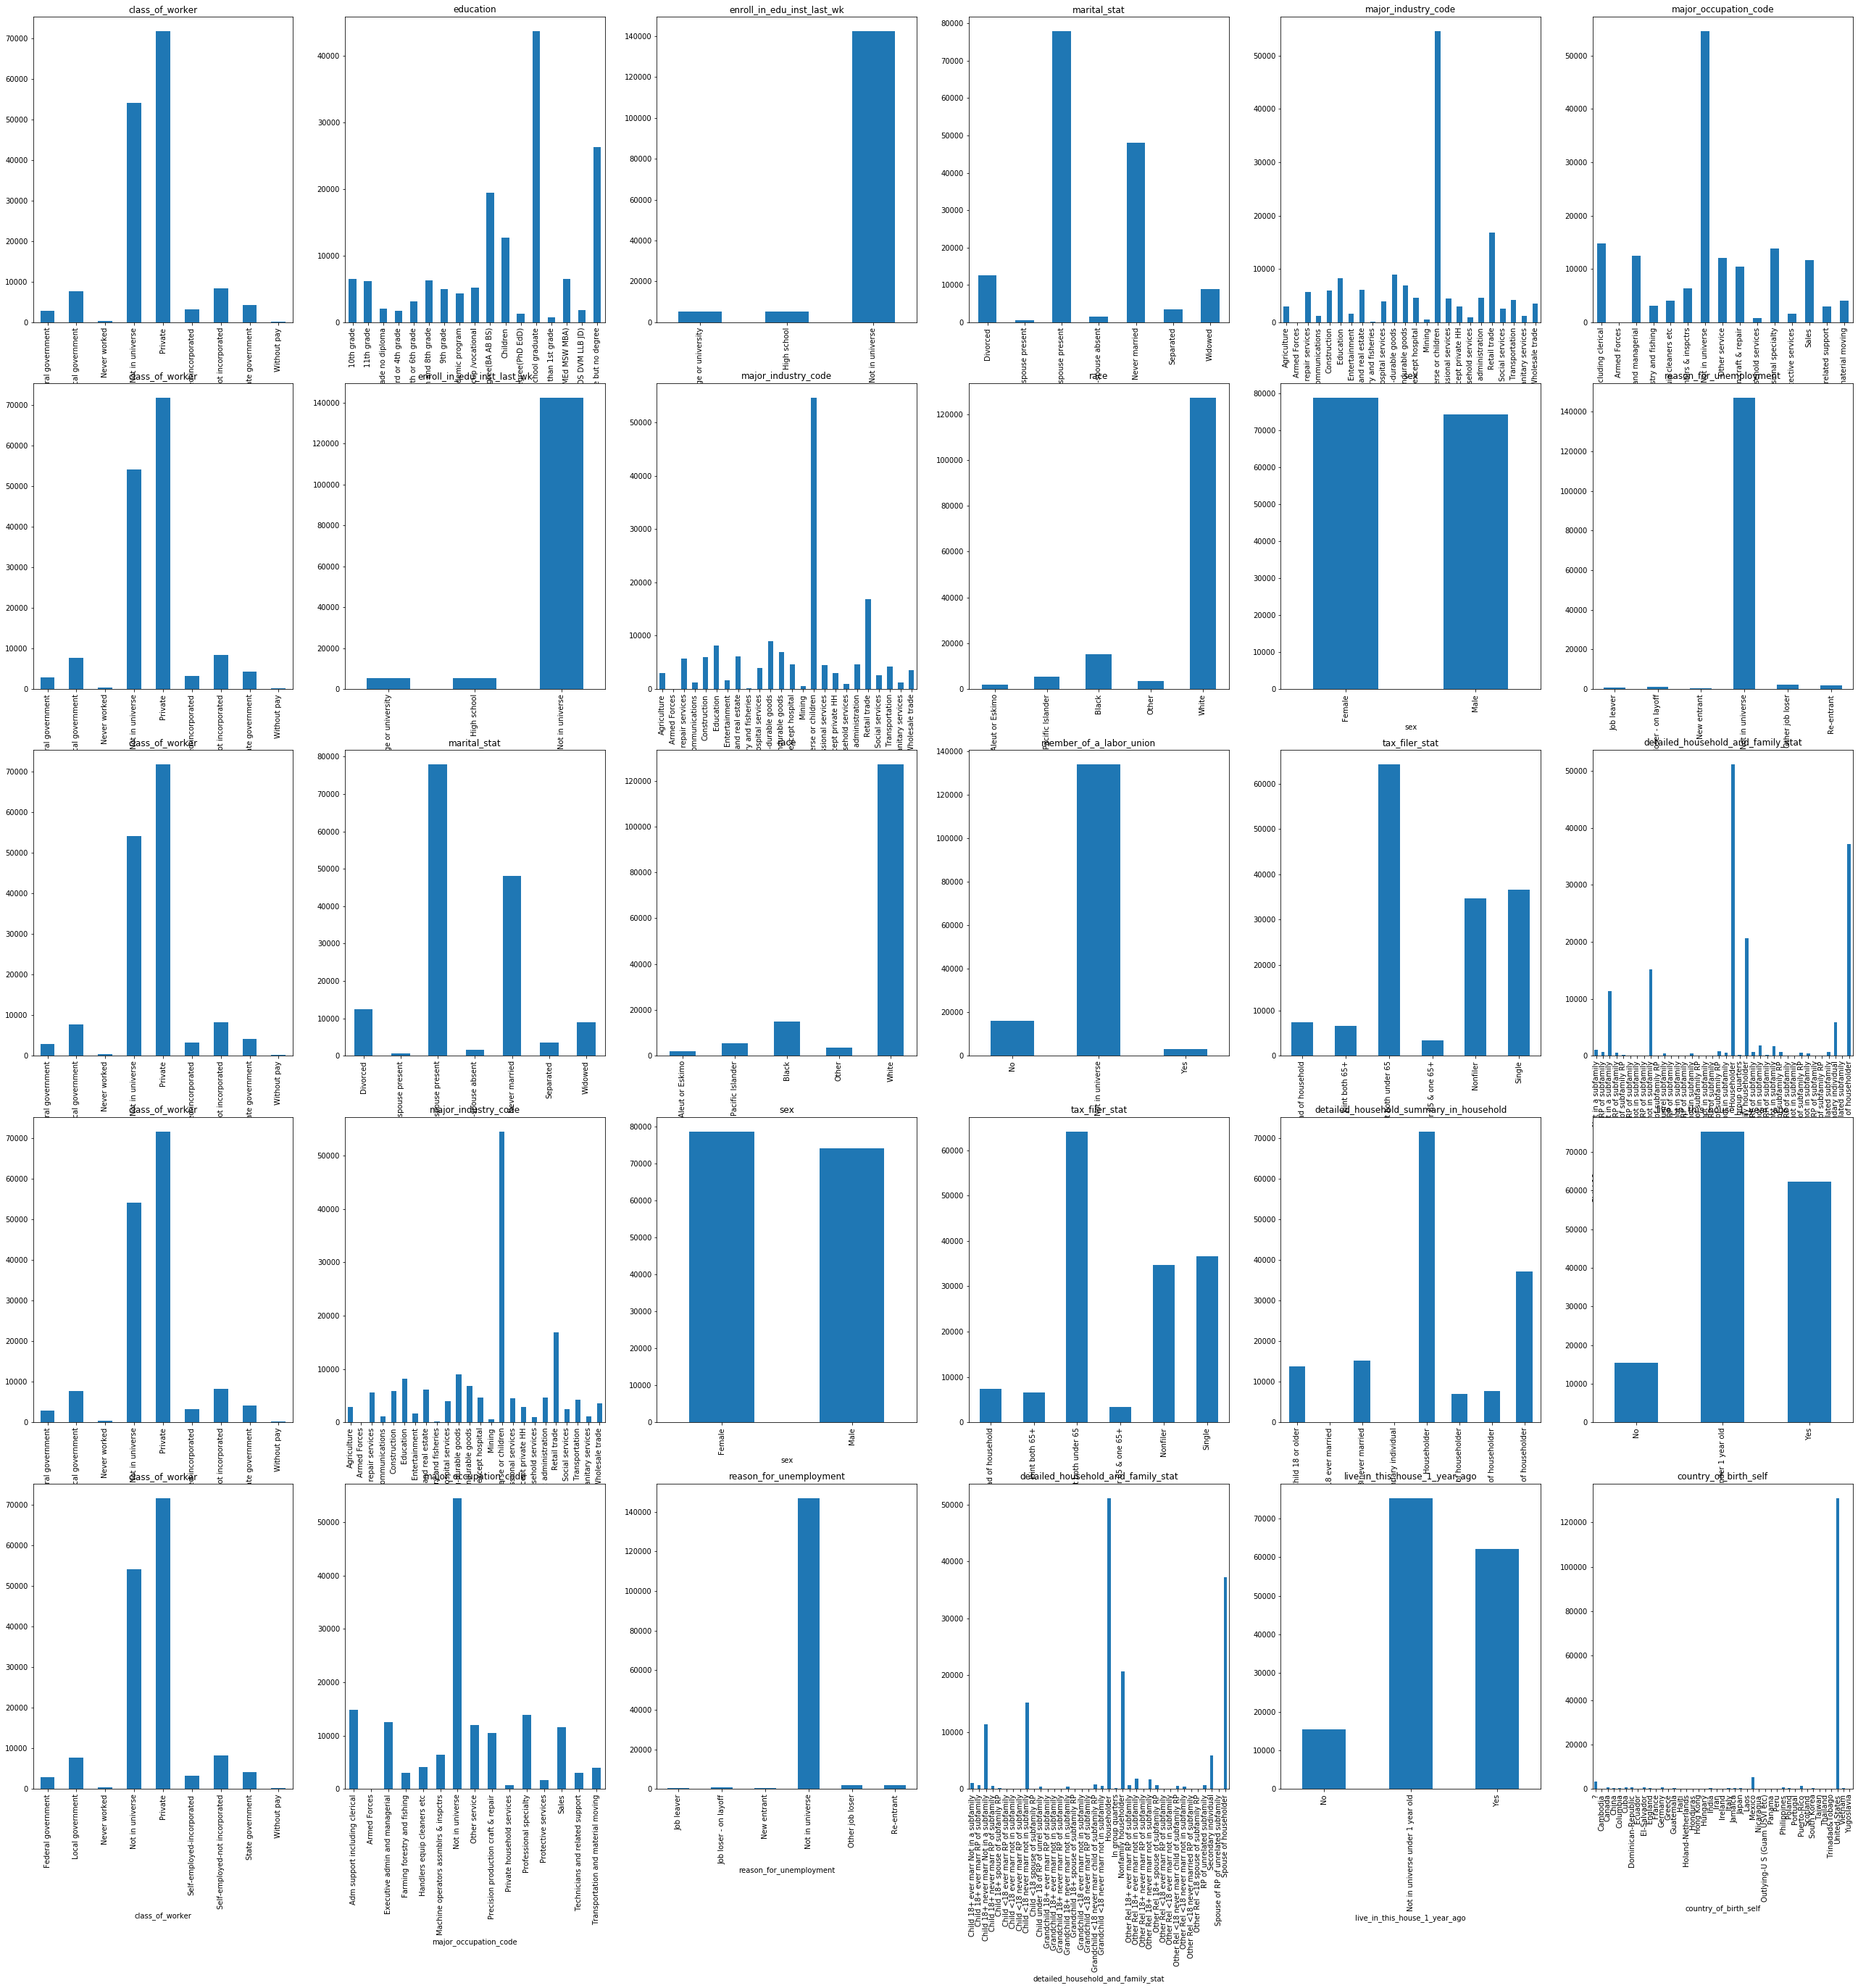

In [13]:
fig, axs = plt.subplots(5,6, figsize=(45,45))
for i in range(5):
    for j in range(6):
        if i==6 and j==5:
            pass
        axs[i,j].set_title(cat_feats[(i+1)*j], fontsize=12)
        train_df[cat_feats].groupby(cat_feats[(i+1)*j]).size().plot(kind='bar', ax=axs[i,j])

**NOTICE:**
* There are some categorical features which are very skewed to particular classes.  For example, consider the class_of_worker (bottom left) feature which is dominated by people either being 'not in universe' or 'private'. Another example, is the 'race' feature (middle left) which shows that the majority of people in this sample are 'White'.

* On the other hand, not all categories are skewed. For example, we can see that the split between 'Male' and 'Female' in the 'Sex' feature is fairly equal, with slightly more 'Female' individuals, as expected.

# Exploring Some Demographic Features

Lets dive into some of the demographic features to see if we can understand how they relate to a person's income.

## Age

Age is a well-known predictor of income.

**HYPOTHESIS**: Older people generally earn more money.

We can check this with a a simple boxplot and showing showing the distribution of the ages of the people earning incomes in each class...

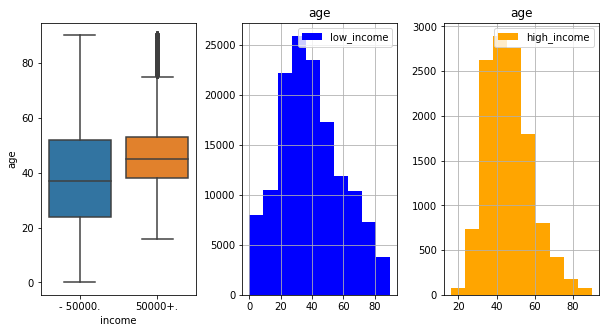

In [14]:
low_income = train_df[train_df['income']=='- 50000.']
high_income = train_df[train_df['income']=='50000+.']

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,5))
sns.boxplot(y='age', x='income', data=train_df, ax=ax1)
low_income.hist(column='age', ax=ax2, color='blue')
ax2.legend(labels=['low_income'])
high_income.hist(column='age', ax=ax3, color='orange')
ax3.legend(labels=['high_income'])

**TAKEAWAY:** if you are earning a higher income (>\\$50,000) you are generally older:
* People are older on average if they are earning >\\$50,000, and there is less variance in the distribution of ages.
* People's ages are distrbiuted unimodaly, regardless of the income they are earning.

### Race

Lets take a closer look at the breakdown of peoples races. Earlier on, we briefly saw that the majority of people in the US census are 'White' - a quick pie chart shows us that 'White' people account for 81% of the people in this dataset.

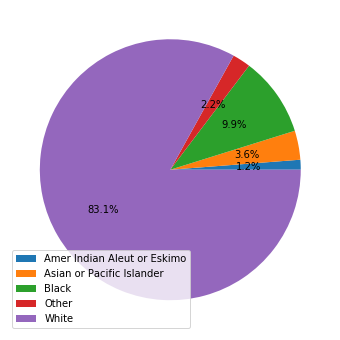

In [15]:
race_group = train_df.groupby('race')['race'].size()
labels = list(race_group.index)
fig = plt.figure(figsize=(6,6))
plt.pie(train_df.groupby('race')['race'].size(), autopct='%1.1f%%')
plt.legend(labels)
plt.show()

**WARNING:** Thsi dataset does not seem to be representative of the current US population. A quick search online leads us to a Wikipedia page that gives a breakdown of current US races - as reported in the 2019 US census. In 2019, the US population was ~63% 'White', whereas our dataset has ~83% of 'White' people.

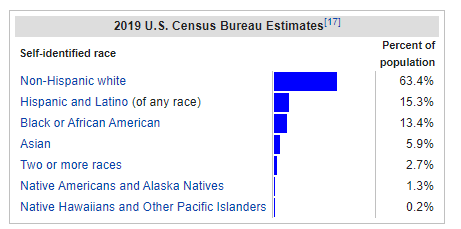

Source: https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States


Racism unfortunately exists...

**HYPOTHESIS**: 'White' indviduals, on average, have higher incomes than people of other races in the US.

In [16]:
income_race_group = train_df.groupby(['race', 'income'])['income'].size().reset_index(name='freq').pivot(index='income', columns='race')
income_race_group = income_race_group.div(income_race_group.sum(axis=1), axis=0)

income_race_group.head()

freq                                      \
race     Amer Indian Aleut or Eskimo Asian or Pacific Islander     Black   
income                                                                     
- 50000.                    0.012980                  0.036092  0.103423   
50000+.                     0.003962                  0.034770  0.043665   

                              
race         Other     White  
income                        
- 50000.  0.023824  0.823681  
50000+.   0.007358  0.910245

<Figure size 576x576 with 0 Axes>

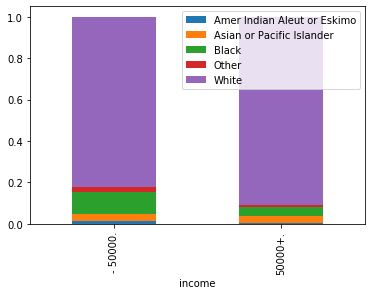

In [17]:
fig = plt.figure(figsize=(8,8))
income_race_group.plot(kind='bar', stacked=True)
plt.legend(labels)
plt.show()

**TAKEAWAY:** There is an income difference across the different races.
* 'White' individuals make up a greater proportion of people who are earning higher incomes. While only ~83% of the individuals in the data are 'White', roughly 91% of higher income individuals are 'White.'
* Conversely, 'Black' individuals appear to form significantly less of the indivduals making >\\$50,000, as compared to people making <\\$50,000. 'Black' individuals make up ~10% of the dataset, while only ~4% of high income indivduals are 'Black'.

### Gender

Gender (the 'sex' feature in this data) is another obvious feature to look into. Again, unfortunately, we are all aware that a gender wage gap exists...

**Hypothesis:** Males are more likely to be making a higher income.

In [18]:
income_gender_group = train_df.groupby(['sex', 'income'])['income'].size().reset_index(name='freq').pivot(index='income', columns='sex')
income_gender_group = income_gender_group.div(income_gender_group.sum(axis=1), axis=0)

income_gender_group.head()

freq          
sex         Female      Male
income                      
- 50000.  0.541148  0.458852
50000+.   0.215008  0.784992

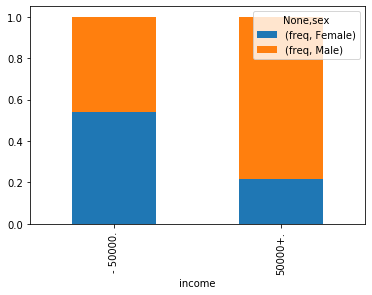

In [19]:
income_gender_group.plot(kind='bar', stacked=True)

**TAKEAWAY:** The proportion of males to females in the low income group is roughly consistent with the split of males to females in the dataset. However, if you are in the high income group you are signficantly more likely to be male than female.

### Race, Age, and Gender

So far we have established:
* People are often older when they make higher incomes.
* 'White' is the most common race in the census, and a larger proportion of high income earners are 'White'.
* Men make a signficantly large proporiton of the high income earners, as compared to females.

**We can tie all 3 insights together...**

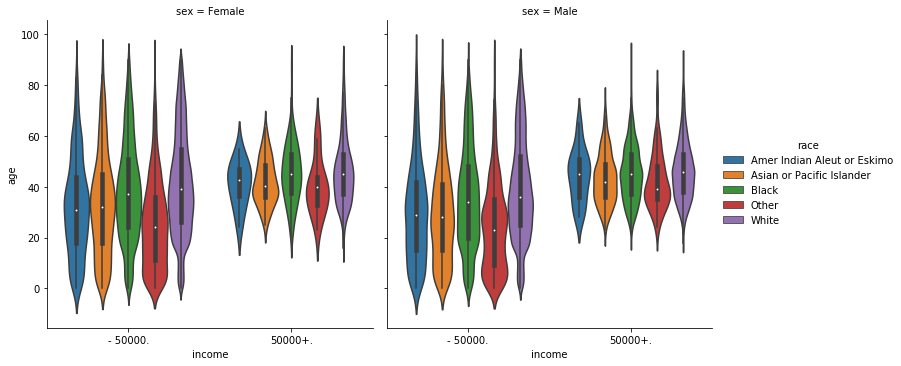

In [20]:
sns.catplot(x='income', y='age', hue='race', col='sex', data=train_df, kind="violin")

# Feature Importance

Before I continue with the exploratory analysis I am going to run a few algortihms to determine the importance of the features. I will then use this to reduce the number of features before exploring them.

There are many different ways to perform feature importance - each of which gives a slightly different results. I will demonstrate 3 different methods to do it:

1. **XGBoost feature importance**
2. **LightGBM feature importance**
3. **RandomForest feature importance**

Finally, to end I will use a permuatation importance test with the XGBoost feature importance method to determine a more robust rank of the feature importance.

**NOTE:** To determine feature importance methods I will have to change the strings of the categorical data strings to numerical values. This can be done easily with Pandas.

In [21]:
def cats_to_codes(df):
    cats = df.select_dtypes('category')
    for col in cats.columns:
        df[col] = df[col].cat.codes
    return df

train_df = cats_to_codes(train_df)
test_df = cats_to_codes(test_df)

# split the training data in X and y
X = train_df.drop(columns=['income'])
y = train_df['income']

train_df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income
0,73,3,0,0,12,0,2,6,14,6,...,40,40,40,4,0,1,2,0,95,0
1,58,6,4,34,16,0,2,0,4,8,...,40,40,40,4,0,1,2,52,94,0
2,18,3,0,0,0,0,1,4,14,6,...,41,41,41,0,0,1,2,0,95,0
3,9,3,0,0,10,0,2,4,14,6,...,40,40,40,4,0,1,0,0,94,0
4,10,3,0,0,10,0,2,4,14,6,...,40,40,40,4,0,1,0,0,94,0


## XGBoost Feature Importance

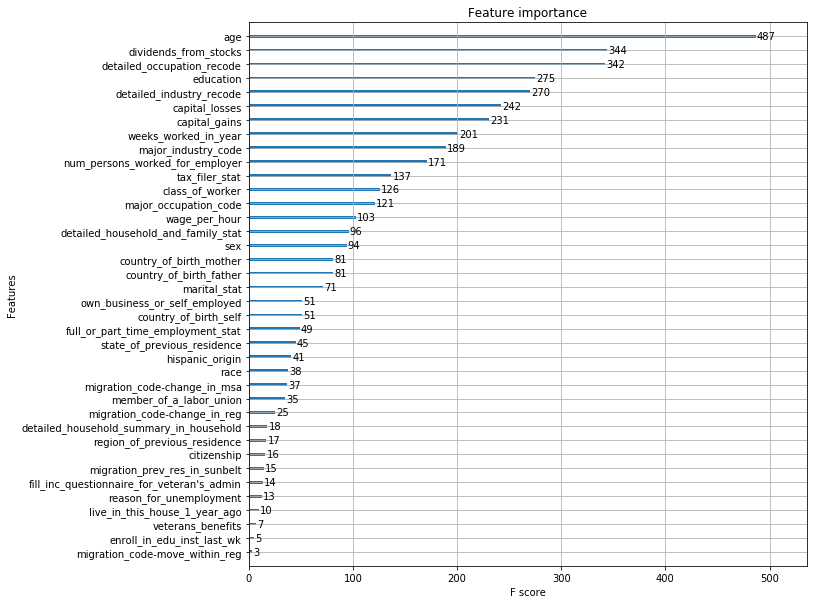

In [22]:
# fit XGBoost model to the training data
bst = XGBClassifier(random_state=0)
bst.fit(X, y)

fig, ax = plt.subplots(figsize=(10,10))
plot_importance(bst, ax=ax)
plt.show()

## LightGBM Feature Importance

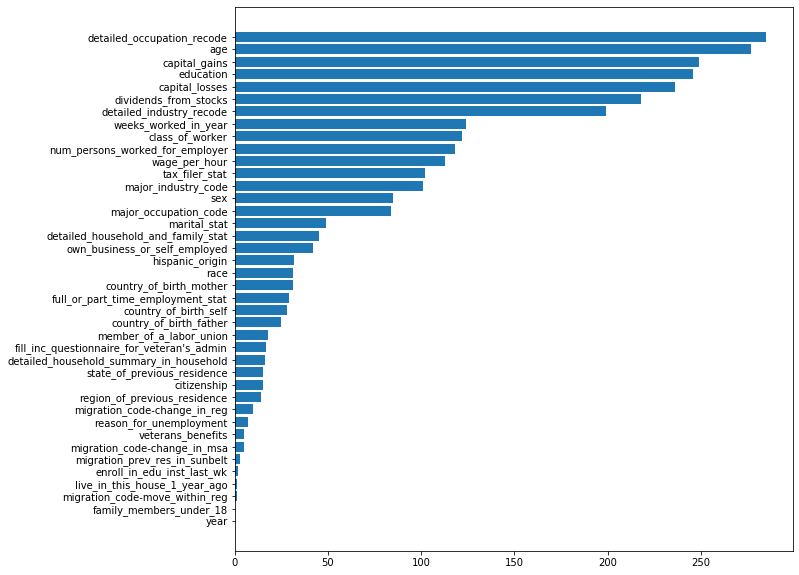

In [23]:
lightGBM = LGBMClassifier(random_state=0)
lightGBM.fit(X, y)

feat_importances = lightGBM.feature_importances_
col_names = np.array(X.columns)
indices = np.argsort(feat_importances)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.barh(y=col_names[indices], width=feat_importances[indices])
plt.show()

## Random Forest Feature Importance

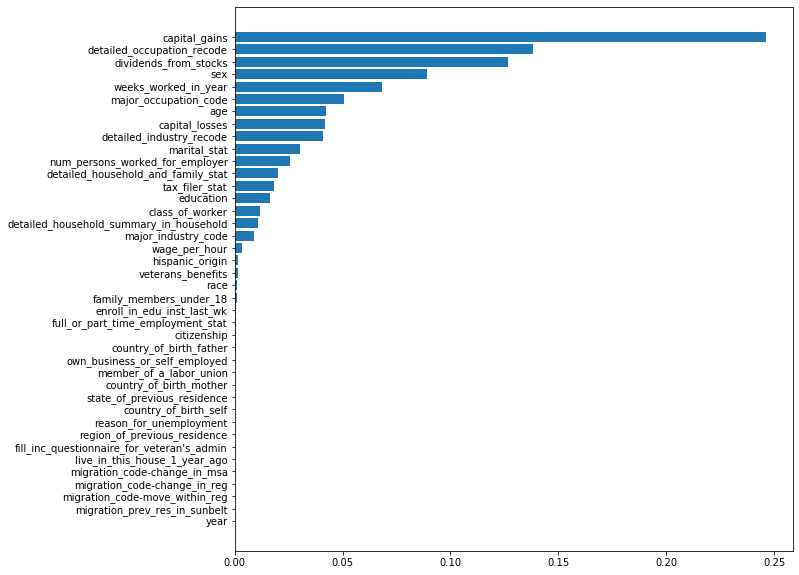

In [24]:
forest = RandomForestClassifier(max_depth=6, random_state=0)

forest.fit(X, y)
feat_importances = forest.feature_importances_

col_names = np.array(X.columns)
indices = np.argsort(feat_importances)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.barh(y=col_names[indices], width=feat_importances[indices])
plt.show()

## Dropping Unimportant Features using Permutation Test of Feature Importances from XGBoost

There are a lot of features so I am going remove the bottom 10 that were found to be unimportant - as determined by the permutation test with the XGBoost feature importance.

**CAUTION:** This is quite a blunt way to remove features, but for the sake of quickly reducing the large number of features I will do it.

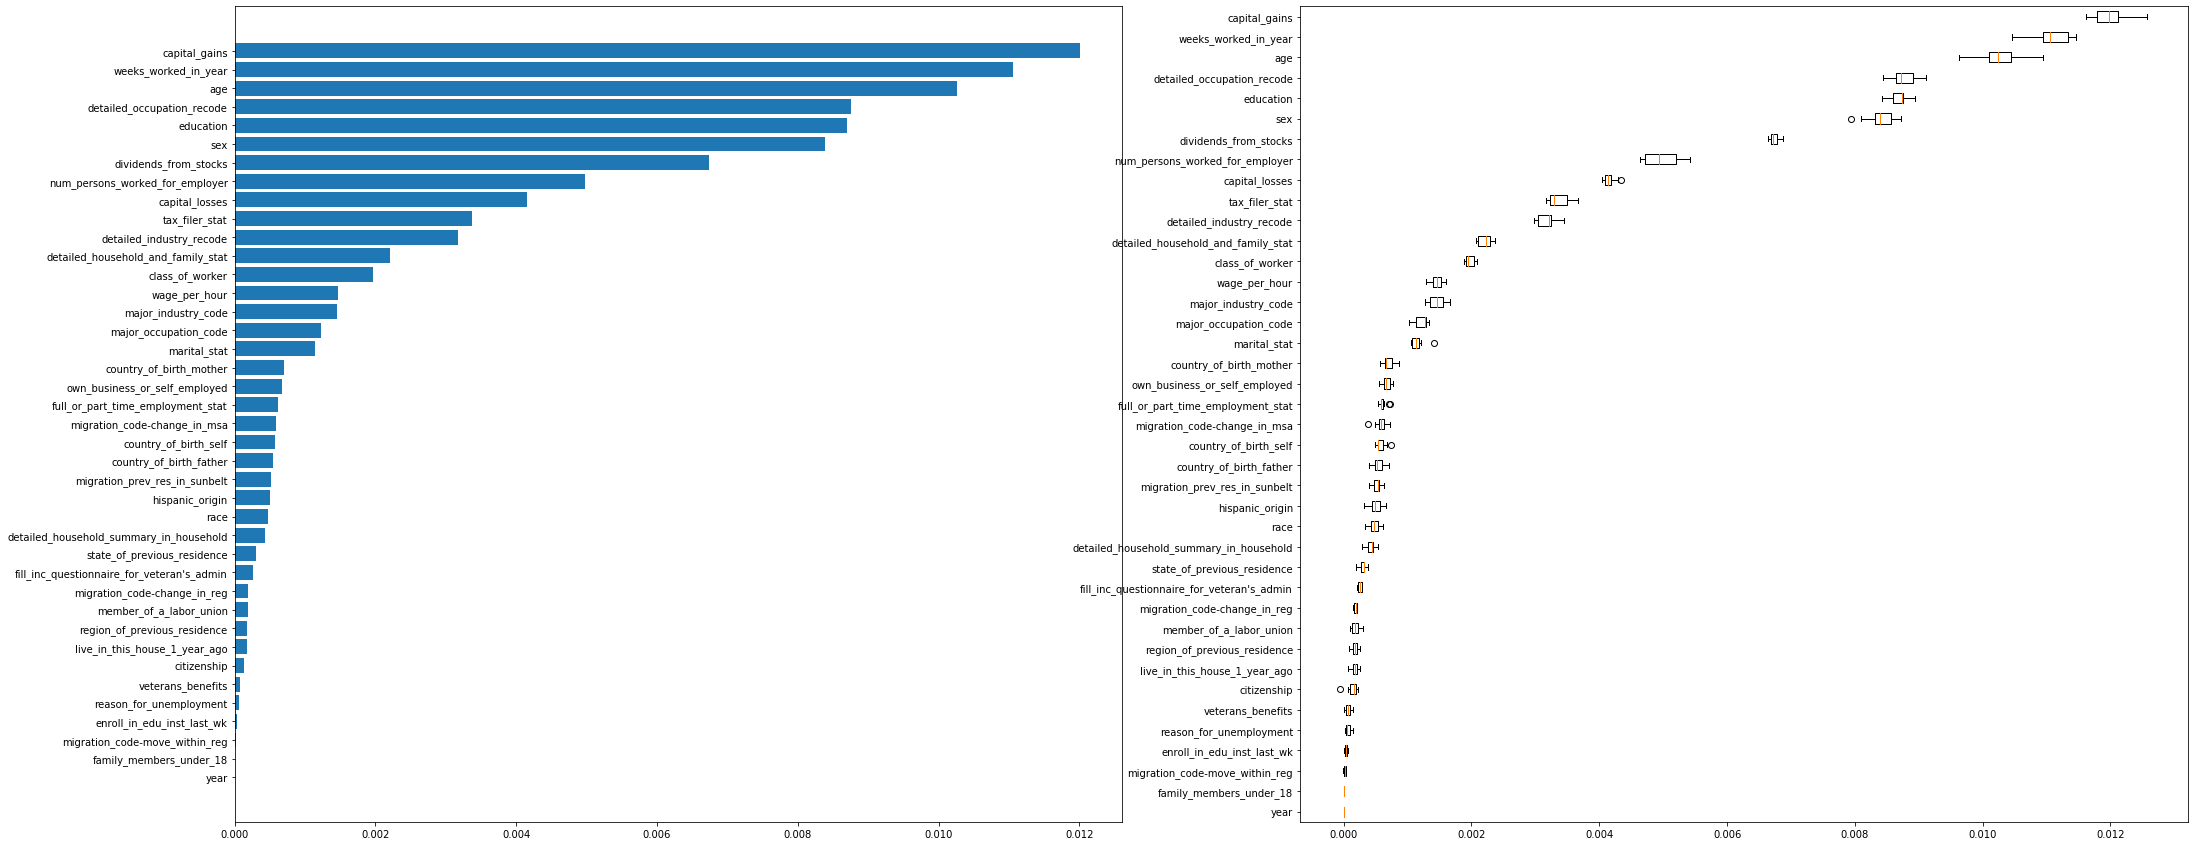

In [25]:
perm_results = permutation_importance(bst, X, y, n_repeats=10, random_state=0)

perm_means = perm_results.importances_mean
perm_stds = perm_results.importances_std
feat_importances = perm_results.importances

col_names = np.array(X.columns)
indices = np.argsort(perm_means)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(35,15))
ax1.barh(y=col_names[indices], width=perm_means[indices])

ax2.boxplot(feat_importances[indices].T, vert=False, labels=list(col_names[indices]))
plt.show()

In [26]:
def drop_unimp_feats(df, cols):
    return df.drop(columns=cols)

unimp_feats = col_names[indices][:10]

train_df = drop_unimp_feats(train_df, unimp_feats)
test_df = drop_unimp_feats(test_df, unimp_feats)

print(train_df.shape, test_df.shape)

(152896, 31) (78864, 31)


# Correlations:

To avoid any issues associated with multicollinearity I will take a look at the correlations between the features. I will then discard any features with an absolute correlation value greater than 0.6.

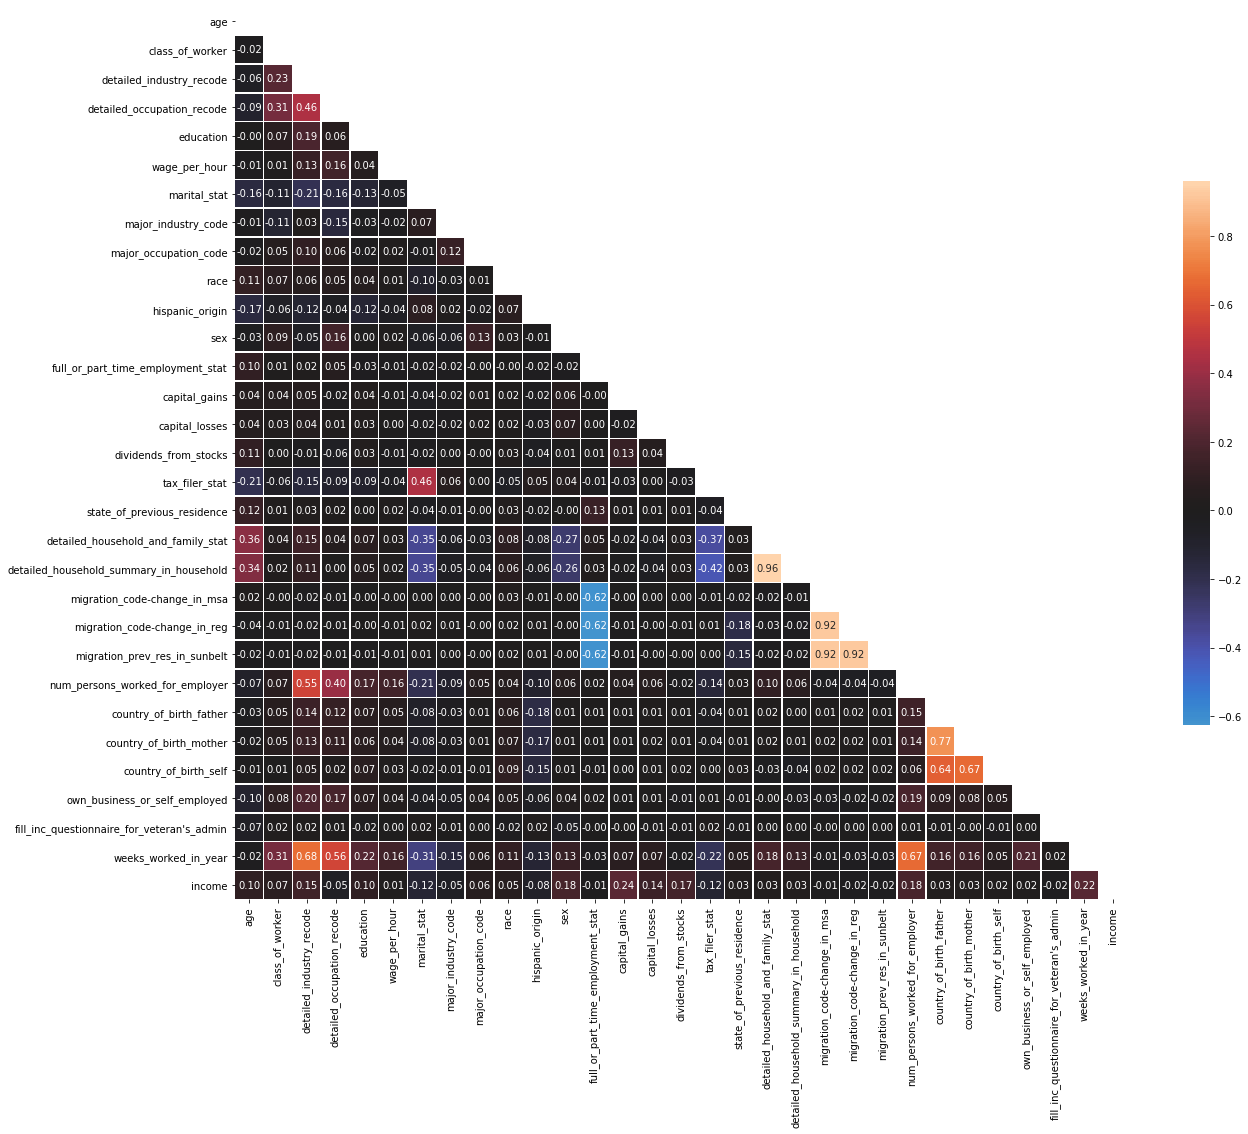

In [27]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the lower triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feratures Most Correlated with Income:

I will just past a snippet from the correlation matrix above so its easier to read. The features most correlated with high income are the columns with the highest positive values:

1. **capital_gains**
2. **weeks_worked_in_year**
3. **num_persons_worked_for_employer**
4. **sex**
5. **dividends_from_stocks**
6. **detailed_industry_recode**
7. **capital_losses**
8. **age**
9. **education**

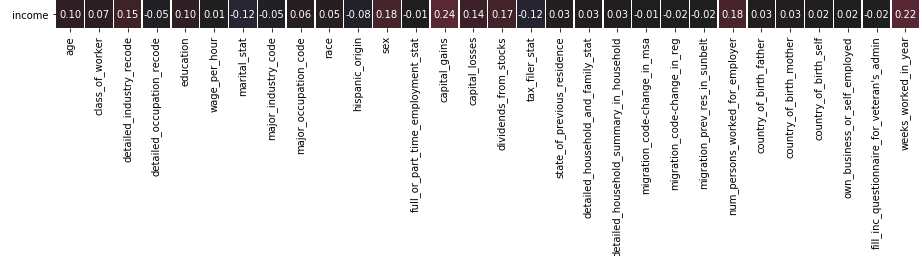

## Dropping Highly Correlated Features

To reduce the problem of multicollinearity I will discard any features which have an absolute correlation value greater than 0.6.

In [28]:
def drop_highCorr_feats(df, cols):
    return df.drop(columns=cols)

# Select upper triangle of correlation matrix
upper = corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.6
highCorr_feats = [column for column in upper.columns if any(upper[column] >= 0.6)]

train_df = drop_highCorr_feats(train_df, highCorr_feats)
test_df = drop_highCorr_feats(test_df, highCorr_feats)

print(train_df.shape, test_df.shape)

(152896, 24) (78864, 24)


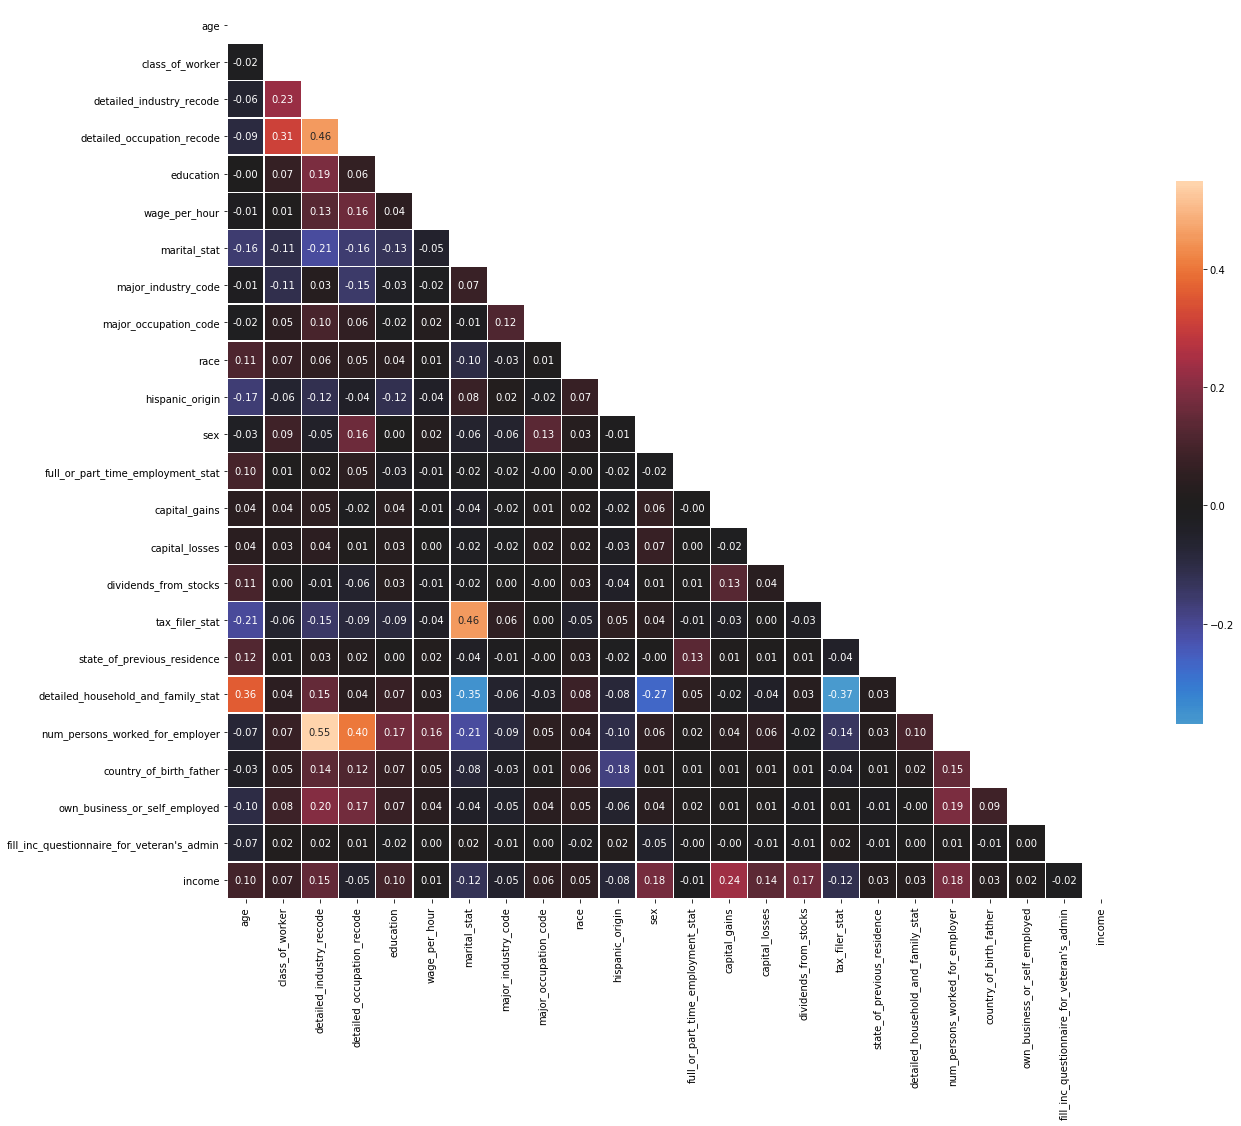

In [29]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the lower triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Splitting the Training Data to Create a Validation Set

I will split the training data into training data and validation data. The validation data will then be used to give an unbiased estimate of how the model will perform on the test data when we come to evaluating the models.  Other methods could include cross-validation techniques, but this method is simpler and quicker to do for the purpose of this task.

In [30]:
X = train_df.drop(columns='income').to_numpy()
y = train_df['income'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3)

In [31]:
X_test = test_df.drop(columns='income').to_numpy()
y_test = test_df['income'].to_numpy()

# Models

To evaluate the performance of the mdoels I will draw on a range of various metrics and plots.
* **Accuracy score:** percentage of predictions that are correct.
* **Balanced accuracy score:** since the data has a large class imbalance a balanced accuracy score is preferred to the regular accuracy score.
* **Precision score:** $= \frac{TP}{TP+FP}$ is the ability of the classifier to not incorrectly label a neagtive sample as positive.
* **Recall score:** $= \frac{TP}{TP+FN}$ is the abilitiy of the classifier to find the positive samples.
* **F1 score:** $= 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$ is a weighted average of the precision and recall scores, with the worst value being 0 and the best value being 1.
* **Confusion Matrix (normalised):** evaluating the accuracy of the model. The entries are $C_{0,0}=TN$, $C_{1,0}=FN$, $C_{0,1}=FP$, and $C_{1,1}=TP$.


**NOTE:** I will not be doing hyperparameter tuning for these models. For improved performance one could perform a grid search (or a random search) over the possible hyperparameter values in order to fine-tune the model for the greatest performance. This evaluation can either be done on a validation set or by using cross validation.

In [32]:
def get_metrics_and_plot_cm(y_val, y_pred):
    acc_score = accuracy_score(y_val, y_pred)
    bal_acc_scr = balanced_accuracy_score(y_val, y_pred)
    prec_scr = precision_score(y_val, y_pred)
    rec_scr = recall_score(y_val, y_pred)
    f1_scr = f1_score(y_val, y_pred)
    print('Accuracy score: \t {:.2f}'.format(acc_score))
    print('Balance accuracy score:  {:.2f}'.format(bal_acc_scr))
    print('Precision score:  \t {:.2f}'.format(prec_scr))
    print('Recall score: \t\t {:.2f}'.format(rec_scr))
    print('F1 score: \t\t {:.2f}'.format(f1_scr))

    cm = confusion_matrix(y_val, y_pred, normalize='true')
    plt.title('Confusion Matrix (normalised)')
    sns.heatmap(cm, annot=True)
    return

## Logistic Regression

Logistic regression is a gold standard when it comes to binary classification and so we will begin here. Logistic regression works to directly model the probability of each sample being a positive class.

In [33]:
logReg = LogisticRegression(penalty='l2', max_iter=200, n_jobs=4, random_state=0)
logReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=4, penalty='l2', random_state=0,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

**WARNING:** This is a good time to showcase what was meant earlier about class imbalances beign a problem for the models.

**NOTICE:** my trained model reports a 93% accuracy. I can also achieve a 92% accuracy by always predicting the majority cass (income=0).

In [34]:
y_pred = logReg.predict(X_val)

print('Accuracy score: {:.2f}'.format(accuracy_score(y_val, y_pred)))

zero_pred = np.zeros_like(y_val)
print('Accuracy score using constant prediction: {:.2f}'.format(accuracy_score(y_val, zero_pred)))

Accuracy score: 0.93
Accuracy score using constant prediction: 0.92


**POSSIBLE SOLUTION:** we should either look towards the resampling methods I mentioned earlier or look towards a different metric. Luckily for us sklearn has a metrics that accounts for this imbalance.

**CHECK:** just to make sure this balanced metric accuracy score is working, we can send through the constant prediction and see what it outputs. I would expect it gives 50% accuracy - it does!

In [35]:
print('Balance accuracy score:  {:.2f}'.format(balanced_accuracy_score(y_val, zero_pred)))

Balance accuracy score:  0.50


**RESULT:**

The logistic regression model obtains a balanced accuracy score of ~60% when predicted on the validation set. I am going to largely ignore commenting on the accurarcy score from here onwards, but I will display it at least.

Accuracy score: 	 0.93
Balance accuracy score:  0.59
Precision score:  	 0.70
Recall score: 		 0.19
F1 score: 		 0.29


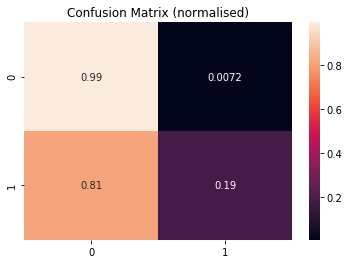

In [36]:
y_pred = logReg.predict(X_val)

# get metrics and plot confusion matrix
get_metrics_and_plot_cm(y_val, y_pred)

## Naive Bayes - Gaussian

Naive Bayes is an extremeley fast classification algorithm that utilisies Bayes theorem to predict classes probabilities. One thing to note is that the aglorithm assumes independece among the features, which as we showed earlier using the correlation matrix, is not true. Another problem with using the Gaussian NB algorithm is that it assumes the features are normally distributed, which as we saw in exploratory analysis was not the case.

However, since the algorithm is inexpensive to compute and usually performs well even when theses assumptions are not true lets see what happens.

In [37]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

**RESULT:**

The Gaussian Naive Bayes model performs better than the logistic regression model, as seen by the higher balanced accuracy score of ~65%. However, note the drop in the precision score. If it is costly to make False Positive (FP) predictions - for example diagnosing someone with cancer - then this model might not be the one you want to deploy. Lets see how the other models perform before making any further comments.

Accuracy score: 	 0.91
Balance accuracy score:  0.65
Precision score:  	 0.43
Recall score: 		 0.34
F1 score: 		 0.38


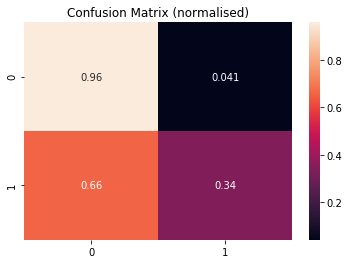

In [38]:
# make predictions
y_pred = gnb.predict(X_val)

# get metrics and plot confusion matrix
get_metrics_and_plot_cm(y_val, y_pred)

## Support Vector Machines - SVM

A support vector machine (SVM) is one of the best 'out of the box' machine learning algorithms to use. It works by trying to seperate the data using hyperplanes with the largest amount of margin between the points. One problem with SVM though is that it is a slow because of the complexity of the algorithm: $O(n_\text{samples}^2 \cdot n_\text{features})$

In [39]:
svmModel = svm.SVC(random_state=0)
svmModel.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

**RESULT:**

This is not an impressive result. The Gaussian Naive Bayes model is still our best performing model. The SVM model is actaully our worst performeing model so far, but strangely it has the highest prevision score (low FP rate) - meaning that it is has a high probabilitiy to not incorrerclty classify negative samples (income=0) as a poitive class (income=1). This might be because the SVM is just not making many correct predictions anyway.

Accuracy score: 	 0.93
Balance accuracy score:  0.58
Precision score:  	 0.82
Recall score: 		 0.15
F1 score: 		 0.26


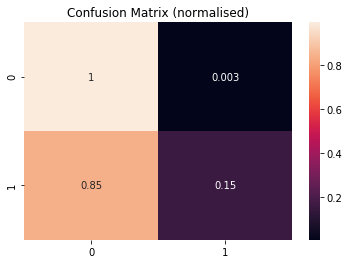

In [40]:
# make predictions
y_pred = svmModel.predict(X_val)

# get metrics and plot confusion matrix
get_metrics_and_plot_cm(y_val, y_pred)

## Random Forest

Random forest is an ensemble learning technique that uses many decision trees to improve model performance. It can be used for classifcation and regression and should not be too impacted by the class imbalance of our data.

In [41]:
rndFor = RandomForestClassifier(max_depth=18, n_jobs=3, random_state=0)
rndFor.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

**RESULT:**

The random forest performs much better than the SVM and logistic regression models, and a little better than the Gaussian Naive Bayes model. It even has a high precision score - this looks promising.

Accuracy score: 	 0.94
Balance accuracy score:  0.69
Precision score:  	 0.78
Recall score: 		 0.39
F1 score: 		 0.52


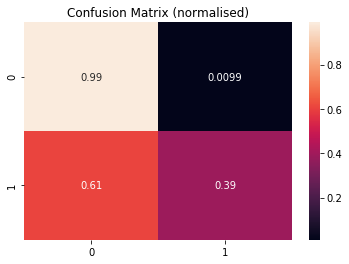

In [42]:
# make predictions
y_pred = rndFor.predict(X_val)

# get metrics and plot confusion matrix
get_metrics_and_plot_cm(y_val, y_pred)

## Gradient Boosting with XGBoost

XGBoost is another ensemble learning method that uses gradient boosting with decision trees to improve mnodel perofrmance. This model should perform better than the standard random forest classifier sicne it is a more powerful model overall.

**NOTE:** I have not used the sklearn library here for XGBoost because this one allows me to utilise a GPU.

In [43]:
# specify parameters via map
params = {'max_depth':18, 'eta':1, 'objective':'binary:logistic', 'tree_method':'gpu_hist', 'predictor':'gpu_predictor'}
num_round = 3

bst = XGBClassifier(**params, random_state=0)
bst.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

**RESULT:**

The XGBoost performs slightly better than the random forest, as expected. There is a slight decrease in the precision score, but an overall higher balanced accuracy. Again, depending on how costly it is to make FP prediction, this could influence your decision as to which model you should chose to deploy.

Accuracy score: 	 0.93
Balance accuracy score:  0.73
Precision score:  	 0.62
Recall score: 		 0.49
F1 score: 		 0.55


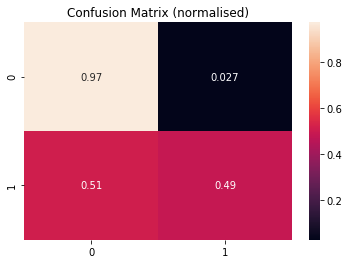

In [44]:
# make predictions
y_pred = bst.predict(X_val)

# get metrics and plot confusion matrix
get_metrics_and_plot_cm(y_val, y_pred)

## Deep Neural Network

finally, I will implemenet a deep neural network using PyTorch. A neural network might, especially a deep one, be a bit overkill for this task, but lets see what happens anyway. I will implement the following:
* **A deep nerual network:** there will be 2 hidden layers between the input and output layers.
* **ReLu activation function:** I like this activation function over the sigmoid one as it makes vanishing/ exploding gradients even less likely. One could also use the Leaky ReLU function which is even better - see image below.

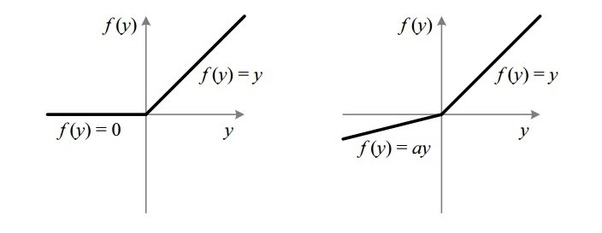

Source: https://qph.fs.quoracdn.net/main-qimg-04f503d241138caef4960cdb56face2d

* **Momentum:** ADAM optimiser has momentum to speed up training.
* **Batch normalisation:** between the input layer and the first hidden layer, between the first hidden layer and the second hidden layer, and between the second hidden layer and output layer. This will help to speed up training.
* **Dropout:** betweent the second hidden layer and the output layer. This will help to regularise the model and prevent overfitting.
* **Early stopping:** to prevent overfitting. I will cut training once the the training loss is greater than it was 10 epochs before.
* **Mini-batch gradient descent:** will help speed up the training. It takes advanatge of the fast updates of stochastic gradient descent and the stabilitiy of full-batch gradient descent.

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [46]:
class CustomDataset(Dataset):
    '''
    A dataset class to help with the batches.
    '''
    def __init__(self,X,y):
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [47]:
class BinaryClassifierNet(nn.Module):
    '''
    A neural net class.
    Includes 2 hidden layers, batch normalisation (x2), and dropout.
    '''
    def __init__(self, n_features):
        super(BinaryClassifierNet, self).__init__()
        # input layer > 1 hidden layers > output_layer
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [49]:
net = BinaryClassifierNet(X_train.shape[1]).to(device)
print(net)

batch_size = 128

# instance of the custom Dataset class
train_ds = CustomDataset(X_train, y_train)
val_ds = CustomDataset(X_val, y_val)

# batch the data with data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=len(val_ds))

# learning rate
lr = 0.000005

# loss function and optimiser
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)

# lists to save losses
train_losses = []
val_losses = []

# best loss to beat
best_loss = 9999

max_epochs = 500
net.train()
for epoch in range(max_epochs):
    # a running loss for the epoch
    running_loss = 0
    
    for i,(X_batch,y_batch) in enumerate(train_loader):
        # send the batches to GPU for speedy computation
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # make predictions
        y_pred = net(X_batch.float())
        
        # calculate the loss
        loss = criterion(y_pred, y_batch.float().unsqueeze(1))
        
        # compute gradients
        loss.backward()
        
        # take a step in direction of gradients
        optimizer.step()
        
        # add the batch loss to the running loss
        running_loss += loss.item()
    
    train_losses.append(running_loss/len(train_loader))
    
    net.eval()
    with torch.no_grad():
        for X_batch,y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = net(X_batch.float())
            val_loss = criterion(y_pred, y_batch.float().unsqueeze(1))
            
            # save best model
            if val_loss<best_loss:
                best_net = net
                
        val_losses.append(val_loss.item()/len(val_loader))
    
    if epoch%25==0:
        print('--------------------------------------------------------------------------------------------')
        print('Training: \t [epoch: {}] \t loss: {:.8f}'.format(epoch, train_losses[-1]))
        print('Validation: \t [epoch: {}] \t loss: {:.8f}'.format(epoch, val_losses[-1]))
        print('--------------------------------------------------------------------------------------------')
    
    # early stopping
    if (epoch>10) and (val_losses[-1]>val_losses[-10]):
        print('Convergence met. Early stopping kicked in.')
        break

BinaryClassifierNet(
  (fc1): Linear(in_features=23, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
--------------------------------------------------------------------------------------------
Training: 	 [epoch: 0] 	 loss: 0.70225922
Validation: 	 [epoch: 0] 	 loss: 0.63051170
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
Training: 	 [epoch: 25] 	 loss: 0.21448970
Validation: 	 [epoch

**RESULTS:**

The neural network does an okay job at classifying the data. Although I haven't put a huge amount of effort into tuning the network I assumed it would have performed better than this. It has a pretty good balanced accuracy score and the highest precision score compared to all the other models, but as I said, I would still have expected a higher accuracy (balanced) given the power of deep neural networks.

Accuracy score: 	 0.93
Balance accuracy score:  0.59
Precision score:  	 0.81
Recall score: 		 0.18
F1 score: 		 0.29


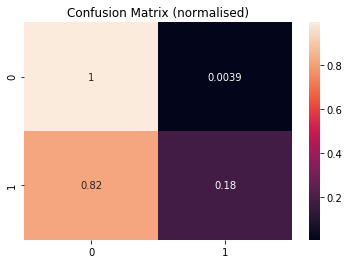

In [50]:
# make predictions with best neural network model
y_pred = best_net(X_batch.float())

# convert probability predictions from tensor torch to numpy, then make proper predictions
y_pred = y_pred.detach().cpu().numpy()
y_pred = np.where(y_pred>=0.5, 1, 0)

# get metrics and plot confusion matrix
get_metrics_and_plot_cm(y_val, y_pred)

**NOTICE:** the network converged qucikly and then couldn't get better. Early stopping did not kick in on this final run I did - in fact, it looks like it could have been trained for longer, but don't forget about diminising returns...

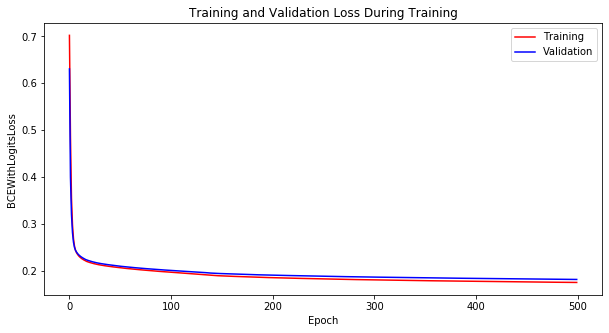

In [51]:
# Plots the loss and accuracy evolution during training 
plt.figure(figsize=(10,5))
plt.plot(train_losses,'r', label='Training')
plt.plot(val_losses, 'b', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('BCEWithLogitsLoss')
plt.title('Training and Validation Loss During Training')
plt.legend()
plt.show()

## Final Model Evaluated on the Test Data

To recap:
* We selected the most important features for our models using a permutation importance test with XGboost feature importances.
* We removed any highly correlated features to reduce the issue of multicollinearity.
* We implemented a selection of different models, including: logistic regression, Gaussian Naive Bayes, SVM, random forest, XGBoost, and a deep neural network.
* We trained the models on the training data.
* We evaluated the models on a validation set which we created by splitting the training data.
* We looked at a range of metrics to evaluate the model performance, including: the accuracy score, the balanced accuracy score, the precision score, the recall score, and the confusion matrix.
    * The balanced accuracy and the precision score were the most insightful - see after thoughts.

<br>

**IMPORTANT:** I hope I have demonstrated the importance of class imbalance; either choses models that can work around it or do some resampling to balance out the classes.

<br>

**MODEL SELECTION:** XGBoost is the model I would chose to generally deploy. Why?
* It performs well on imbalanced data - it achieved the highest balanced accuracy score and a high precision score.
* It has the addittional benefit of being about to work out the box with little configuration needed.
* It has GPU capabilities to increase training spped.
* It can be used for classifcation and regression problems alike.

<br>

**OTHER POINTS TO CONSIDER WHEN SELECTING A MODEL:**
* The random forest model came in close second: it had a good balanced accuracy score and a slightly better precision score, as compared to the XGBoost model. If False Positives (FP) predictions are very costly then a high precision is preferred which could possibly mean favouring the random forest model over the XGBoost model.
* If interpretability of the model is important then perhaps the logistic regression model is the best model to go with.
    * We saw that it did not achieve a a particualrly good (balanced) accuracy score, but with some resampling techniques to reblanace the classes, some feature engingeering and some more preprocessing of the data I am confident its performance can be greatly increased.
    * Furthermore, if the features are standardised the we can compare the importance and predictive powerr of the features easily by comparing the model coefficient sizes.
    * We might even be able to skip the feature importance steps from earlier by performing forwad-mode, backward-mode, or k-subset feature selection methods with the logistic regression.
* No hyperparameter tuning was done. This can help to squeeze some extra performance out of the models. Furthemore, the models were trained with random seeds for reproducability purposes, but this probably lowered their performance.
* No feature engineering was done. This can massively improve the performance. The only exception to this really is the deep neural network which can essentially create its own latent features deep in the network.
* I'm convinced the neural network should have performed much better. This would be my interest if I had more time for future work.

<br>

**RESULT:** The model performs almost as well as it did when we evaluted it on the validation set. This is not too suprising since the purpose of using the validation set was to provide an unbiased estimator of how the model will perform on the test set. At least we know it worked!

Accuracy score: 	 0.94
Balance accuracy score:  0.71
Precision score:  	 0.66
Recall score: 		 0.43
F1 score: 		 0.52


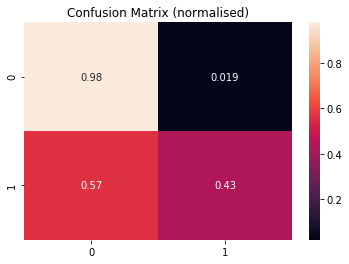

In [52]:
y_pred = bst.predict(X_test)

get_metrics_and_plot_cm(y_test, y_pred)

# After Thoughts:

* For me, the exploratory analysis was the most challenging part about the exercise. With more time I would dive deeper into the features to gain more insight, but since the final goal was to compare model performance I moved on switfly to the analysis. However, if the project had been an infernece task, I would have done much more exploratory analysis. I probably have much to learn about this area of work and I expect (hope) it comes with experience.

* No features were engineered in this task. This would be a recommendation for future work. This would also be helped if more exploratory analysis was conducted.

* I noted earlier that the some of the continious features were skewed, spanned different vastly different ranges, and had outliers. This would also be a recommendation for futurue work.

* There were a lot of features so it was helpful to the drop the least important ones using the permutation importance test of feature importances found via XGBoost. Additionally, to reduce the issues of multicollinearity, the highly correlated features were also removed which further helped to reduce the number of features.

* The class imbalance was a problem for some of the models used in this work. I tried to be clear about this problem at the beginning and later demonstrated my point by comparing the accuracy score of a traine logisiic regression model to a constant prediction of the majority class (income=0) - see the end of the logistic regression part. It would be worth performing some resampling technqiues to rebalance the dataset, or focusing more on models (like tree-based methods) which are less impacted by the class imbalance.

* I chose to report precision and recall instead of false positive rate (FPR) and true positive rate (TPR). While recall and TPR are the same, precision and FPR are not. Since the classes are so highly imbalanced - being heavily skewed towards the negative class (income=0) - I thought FPR was not appropriate to use as it is too focused on the negative class. On the other hand, the precision is more focused on the positive class and as it tells us the probability of correctly detecting positive values. If one were to go down the route of reporting FPR and TPR then it might also be worthwhile to supplement the analysius with ROC curves and AUC metrics.

* Recall that we found the following feratures to be most positively correlated with higher income:
    1. **capital_gains**
    2. **weeks_worked_in_year**
    3. **num_persons_worked_for_employer**
    4. **sex**
    5. **dividends_from_stocks**
    6. **detailed_industry_recode**
    7. **capital_losses**
    8. **age**
    9. **education**


* I thought the deep neural network would be overkill for this task, but it turns out it wasn't. Am I missing any else thats obvious?  See the 'EXTRA' section at bottom if interest (hint: I rebalance the classes for improved performance).

# EXTRA: Rebalanced Data with Neural Network
I was curious why my neural network didn't perform as well as a some of the other models. I went back and did a very quick reblancing of the data - no stratification (so beware) - and then re-ran the training.

In [53]:
train_high = train_df[train_df['income']==1]
train_low = train_df[train_df['income']==0].sample(n=12367)

new_train_df = pd.concat([train_high, train_low]).sample(frac=1)

X_new = new_train_df.drop(columns='income').to_numpy()
y_new = new_train_df['income'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X_new,y_new, test_size=0.3)

In [54]:
net = BinaryClassifierNet(X_train.shape[1]).to(device)
print(net)

batch_size = 128

# instance of the custom Dataset class
train_ds = CustomDataset(X_train, y_train)
val_ds = CustomDataset(X_val, y_val)

# batch the data with data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=len(val_ds))

# learning rate
lr = 0.000005

# loss function and optimiser
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)

# lists to save losses
train_losses = []
val_losses = []

# best loss to beat
best_loss = 9999

max_epochs = 500
net.train()
for epoch in range(max_epochs):
    # a running loss for the epoch
    running_loss = 0
    
    for i,(X_batch,y_batch) in enumerate(train_loader):
        # send the batches to GPU for speedy computation
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # make predictions
        y_pred = net(X_batch.float())
        
        # calculate the loss
        loss = criterion(y_pred, y_batch.float().unsqueeze(1))
        
        # compute gradients
        loss.backward()
        
        # take a step in direction of gradients
        optimizer.step()
        
        # add the batch loss to the running loss
        running_loss += loss.item() / len(y_batch)
    
    train_losses.append(running_loss)
    
    net.eval()
    with torch.no_grad():
        for X_batch,y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = net(X_batch.float())
            val_loss = criterion(y_pred, y_batch.float().unsqueeze(1))
            
            # save best model
            if val_loss<best_loss:
                best_net = net
                
        val_losses.append(val_loss.item()/len(val_loader))
    
    if epoch%25==0:
        print('--------------------------------------------------------------------------------------------')
        print('Training: \t [epoch: {}] \t loss: {:.8f}'.format(epoch, train_losses[-1]))
        print('Validation: \t [epoch: {}] \t loss: {:.8f}'.format(epoch, val_losses[-1]))
        print('--------------------------------------------------------------------------------------------')
    
    # early stopping
    if (epoch>10) and (val_losses[-1]>val_losses[-10]):
        print('Convergence met. Early stopping kicked in.')
        break

BinaryClassifierNet(
  (fc1): Linear(in_features=23, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
--------------------------------------------------------------------------------------------
Training: 	 [epoch: 0] 	 loss: 0.82031346
Validation: 	 [epoch: 0] 	 loss: 0.73968697
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
Training: 	 [epoch: 25] 	 loss: 0.60003432
Validation: 	 [epoch

## Evaluating on Validation Data

Less training data meant less batches which meant faster epochs and faster training time.

**GOOD NEWS:**
* The stanadrd accuracy score now holds more signifcance - see how its roughly the same as the balanced accuracy metric. It is much higher than before!
* The other metrics are higher too.

Hopefully further demonstrates the purpose of resampling when working with imbalanced data.

Accuracy score: 	 0.80
Balance accuracy score:  0.80
Precision score:  	 0.82
Recall score: 		 0.77
F1 score: 		 0.80


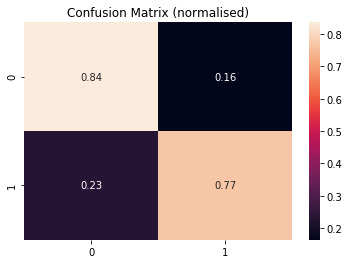

In [55]:
# make predictions with best neural network model
y_pred = best_net(X_batch.float())

# convert probability predictions from tensor torch to numpy, then make proper predictions
y_pred = y_pred.detach().cpu().numpy()
y_pred = np.where(y_pred>=0.5, 1, 0)

# get metrics and plot confusion matrix
get_metrics_and_plot_cm(y_val, y_pred)

**NOTICE:** that early stopping does kick in this time.

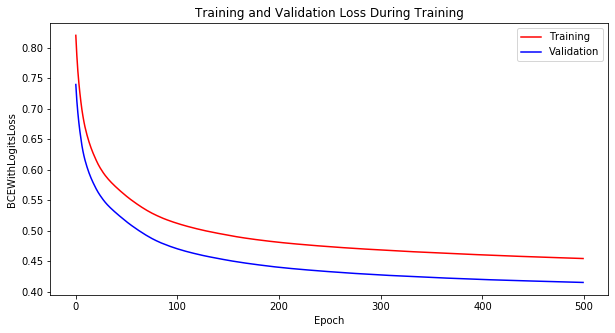

In [56]:
# Plots the loss and accuracy evolution during training 
plt.figure(figsize=(10,5))
plt.plot(train_losses,'r', label='Training')
plt.plot(val_losses, 'b', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('BCEWithLogitsLoss')
plt.title('Training and Validation Loss During Training')
plt.legend()
plt.show()

## Final Evaluation on the Test Data

**RESULT:** the accuracy (and balanced accuracy) of this model is now much higher than the balanced accuracy of the previous model. It even beats the XGBoost model!

Accuracy score: 	 0.82
Balance accuracy score:  0.80
Precision score:  	 0.28
Recall score: 		 0.77
F1 score: 		 0.41


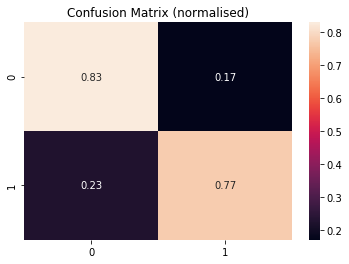

In [60]:
test_ds = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=len(test_ds))

for X_batch,y_batch in test_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    
    # make predictions with best neural network model
    y_pred = best_net(X_batch.float())

    # convert probability predictions from tensor torch to numpy, then make proper predictions
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.where(y_pred>=0.5, 1, 0)

    # get metrics and plot confusion matrix
    get_metrics_and_plot_cm(y_test, y_pred)